# method - 1 (full analytical solution first)

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

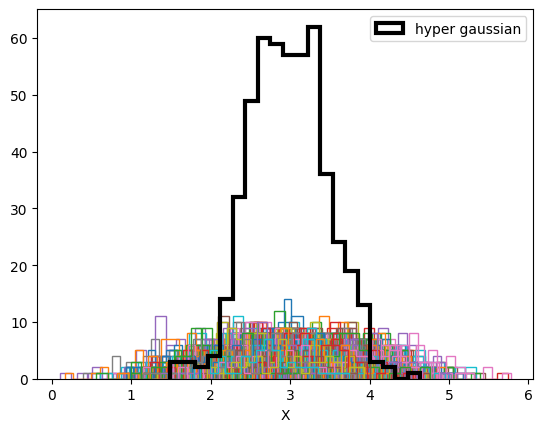

In [2]:
def generate_data(mean, scale, size):
    """
    Function to generate a Gaussian distribution with specified mean, scale and size. 
    """
    return np.random.normal(loc=mean, scale=scale, size=size)

# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 500
size_child = 50

# Hypothesis for parent gaussian 
parent_gaussian = generate_data(true_parent_mean, true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

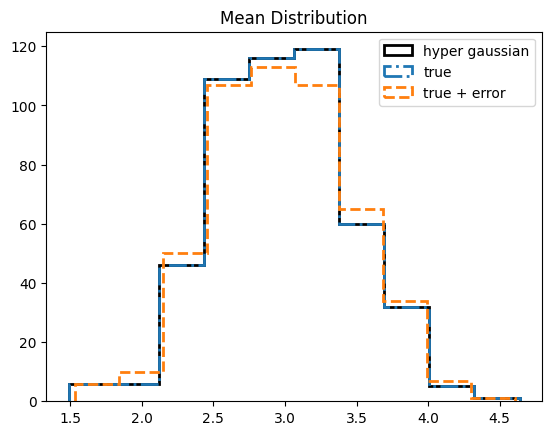

In [3]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [4]:
def log_likelihood(params):
    parent_mean, parent_scale = params

    weights = np.log(np.sum(
                (2 * np.pi * true_child_scale**2)**(-0.5) * \
                np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / \
                (2 * true_child_scale**2)),
                axis=1))
    chi_sq = ((child_gaussian.mean(axis=1) - parent_mean)**2 / (2 * parent_scale**2))
    
    return - 0.5 * N_obs * np.log(2 * np.pi * parent_scale**2 * size_child**2) - np.sum(chi_sq + weights)

In [5]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
mu_ml, sigma_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 2.982
sigma = 0.490


In [6]:
def log_prior(params):
    parent_mean, parent_scale = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 5):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [7]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:15<00:00, 126.36it/s]


State([[2.98073861 0.48135724]
 [3.01467073 0.47795655]
 [2.96323992 0.53975609]
 [2.99688657 0.4808766 ]
 [2.99719509 0.48520006]
 [2.94525935 0.48595526]
 [2.99927958 0.47879069]
 [2.98590335 0.4714594 ]
 [3.03607711 0.47863987]
 [3.00022055 0.47703184]
 [2.98868873 0.50798552]
 [2.95124504 0.52370657]
 [2.9851687  0.50269087]
 [2.94612679 0.50239059]
 [2.99275525 0.50017377]
 [2.95149311 0.49617554]
 [2.95216565 0.50433537]
 [2.97087276 0.47798001]
 [2.98197553 0.5084806 ]
 [2.98717001 0.50000537]
 [2.98340467 0.49594461]
 [2.99961459 0.49549294]
 [2.97459572 0.49555535]
 [2.9600923  0.52521469]
 [3.0204125  0.46929078]
 [2.97581593 0.47151846]
 [2.96435693 0.48330016]
 [2.96345536 0.46898882]
 [3.02065531 0.49299593]
 [2.96725003 0.52119538]
 [2.98425764 0.48511516]
 [2.96035977 0.48994164]
 [2.98977748 0.50033399]
 [2.98088022 0.49843408]
 [2.9871205  0.49103745]
 [3.00341005 0.47464035]
 [2.95309196 0.49645486]
 [2.9886554  0.47189544]
 [2.9914309  0.49268702]
 [3.01880017 0.4880

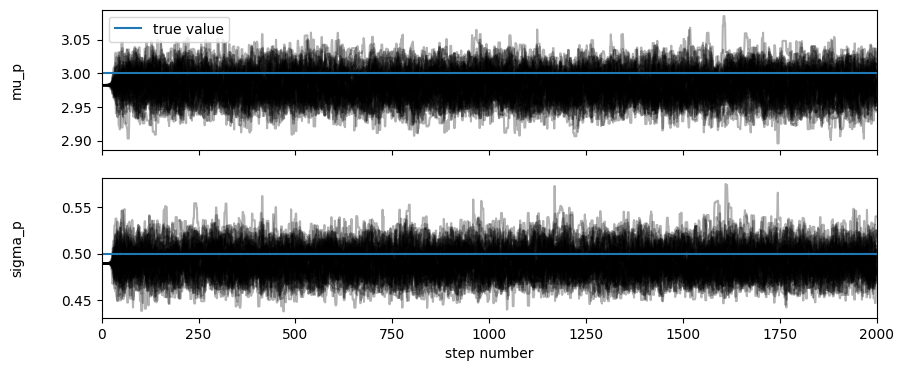

In [8]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [9]:
tau = sampler.get_autocorr_time()
print(tau)

[27.79796609 26.60428855]


In [10]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(6500, 2)


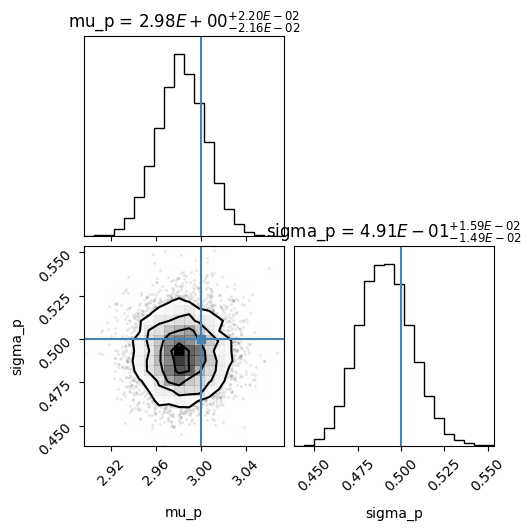

In [11]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# method - 2 (generalized case) 
See overleaf file for formulation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 10.0)

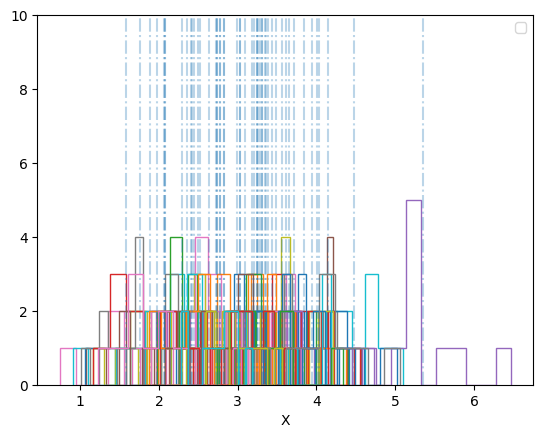

In [2]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 50
size_child = 10

# Hypothesis for parent gaussian 
## draws from parent  for mu child
true_parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)*true_child_scale, axis=1)
true_child_gaussian = np.random.normal(loc=true_parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(true_child_gaussian[i], fill=False, histtype='step')
    plt.vlines(np.mean(true_child_gaussian[i]), 0, size_child, linestyles='-.', alpha=0.3)
#plt.hist(true_parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian')
plt.xlabel("X")
plt.legend()
plt.ylim(0,size_child)

In [3]:
def log_prior(params):
    parent_mean, parent_scale = params
    
    ## randomly generate samples of observation from the hyperprior
    child_means = np.random.randn(N_obs) * parent_scale + parent_mean
    return np.random.normal(loc=child_means[:, None] , scale=true_child_scale, size=(N_obs, size_child)) # adding noise ?

def log_hyperprior(params):
    parent_mean, parent_scale = params
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_likelihood(params):
    parent_mean, parent_scale = params
    samples_mu_child = true_child_gaussian # this has to be the true value whic has to be passed as in the observed value

    ##  \frac{1}{N_i} \sum_{j=1}^{N_i} \frac{1}{\sqrt{2\pi\sigma_p^2}} \exp(-\frac{(\mu_i^j-\mu_p)^2}{2\sigma_p^2})

    # likelihood = 1
    # for samples in samples_mu_child:
    #     this_L = np.mean((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples-parent_mean)**2 / (2 * parent_scale**2)))
    #     #mean = sum/size_child
    #     likelihood *= this_L
    
    ## These two lines represent what above loop does
    #mean = size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)
    #likelihood = np.prod(mean)
    
    return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))

def log_probability(params):
    log_prior_val = log_hyperprior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [4]:
import emcee

pos = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2) + 1e-6 * np.random.randn(20, 2)
nwalkers, ndim = pos.shape

#from multiprocessing import Pool

#with Pool() as pool:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,
)
sampler.run_mcmc(pos, 5000, progress=True)

 14%|█▍        | 721/5000 [00:00<00:01, 2402.30it/s]/tmp/ipykernel_16703/1647390965.py:31: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))
100%|██████████| 5000/5000 [00:02<00:00, 2449.17it/s]


State([[3.15870049 0.69291657]
 [2.95282958 0.69847419]
 [3.26185698 0.66325785]
 [2.97445122 0.66138253]
 [3.09425334 0.7614981 ]
 [3.06290913 0.65383363]
 [3.0509154  0.71837452]
 [3.07887288 0.4977976 ]
 [3.03949644 0.65832854]
 [3.10449236 0.82023508]
 [3.08435928 0.53696395]
 [2.98257783 0.63835279]
 [3.03655763 0.80256828]
 [2.95699347 0.60114728]
 [3.13414739 0.53166092]
 [3.20551646 0.90886154]
 [3.03973535 0.62519278]
 [3.16141152 0.68177818]
 [2.92419342 0.69191107]
 [3.13045351 0.78586381]], log_prob=[-57.27347883 -57.28521629 -58.31212436 -56.91795825 -57.67922807
 -56.64189442 -57.1134974  -57.81666468 -56.66774942 -58.58996444
 -57.11921678 -56.7992716  -58.2296397  -57.01608835 -57.44244879
 -60.73391578 -56.57839877 -57.21727815 -57.47360615 -58.15274561], blobs=None, random_state=('MT19937', array([  41867298, 2657636638, 2884763864, 3844649946, 2926899224,
       1807944622,  667106835,  502126014,  609821724,  260188234,
       3153817932, 2537906260, 2267949116, 335

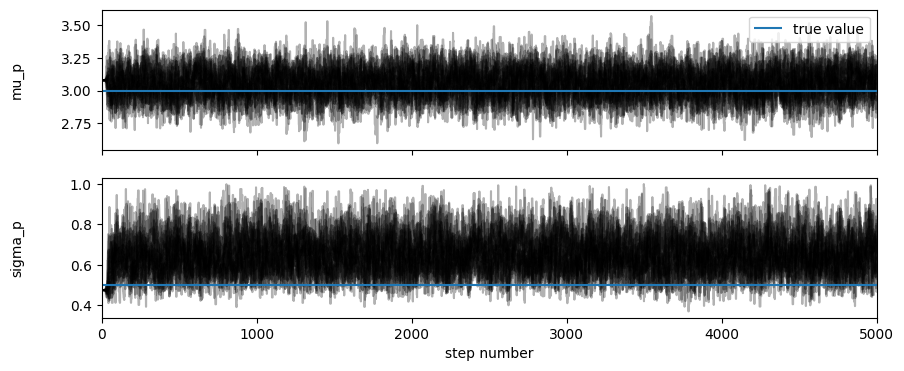

In [5]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [6]:
tau = sampler.get_autocorr_time()
print(tau)

[31.50202473 33.85268284]


In [7]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(6600, 2)


In [12]:
np.mean(flat_samples[:,0])

3.056529886561892

In [13]:
np.mean(flat_samples[:,1])

0.6498177697173048

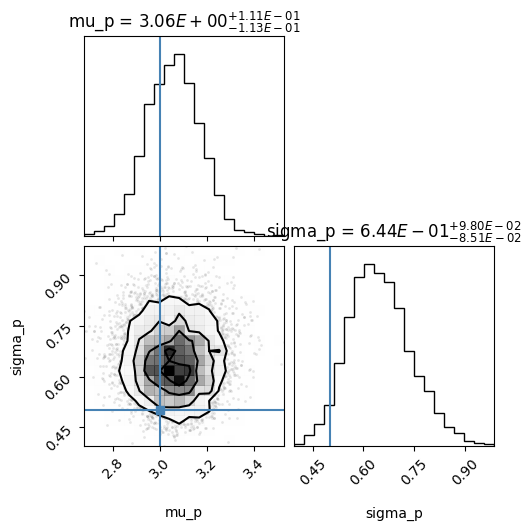

In [8]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# P-P plots 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import emcee

In [2]:
MU_P_LOW = 0
MU_P_HIGH = 5
SIGAM_P_LOW = 0
SIGMA_P_HIGH = 1
MU_P = np.random.uniform(MU_P_LOW, MU_P_HIGH, 50)
SIGMA_P = np.random.uniform(SIGAM_P_LOW, SIGMA_P_HIGH, 50)

In [3]:
N_obs = 100
size_child = 50

MU_P_RECORDED = []
SIGMA_P_RECORDED = []

In [4]:
def log_hyperprior(params):
    parent_mean, parent_scale = params
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_likelihood(params):
    parent_mean, parent_scale = params
    samples_mu_child = true_child_gaussian
    return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))

def log_probability(params):
    log_prior_val = log_hyperprior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [5]:
for true_parent_mean in MU_P:
    
    true_parent_scale = .5
    true_child_scale = 0.5

    # Hypothesis for parent gaussian 
    true_parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

    # Add scatter on the child mean because the data for a signal is signal + noise
    err_on_mean_child = np.expand_dims(np.random.randn(N_obs)*true_child_scale, axis=1)
    true_child_gaussian = np.random.normal(loc=true_parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

    pos = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2) + 1e-6 * np.random.randn(20, 2)
    nwalkers, ndim = pos.shape

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, pool=pool
        )
        sampler.run_mcmc(pos, 5000, progress=True)
        
    flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
    MU_P_RECORDED.append(np.mean(flat_samples[:,0]))

 75%|███████▍  | 3728/5000 [00:05<00:01, 660.26it/s]/tmp/ipykernel_28614/4260181119.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))
 14%|█▎        | 677/5000 [00:01<00:06, 676.06it/s]/tmp/ipykernel_28614/4260181119.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))
 19%|█▉        | 945/5000 [00:01<00:06, 657.49it/s]/tmp/ipykernel_28614/4260181119.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))
 82%|████████▏ | 4109/5000 [00:06<00:01, 607.05it/s]/tmp/ipykernel_28614/4260181119.

In [6]:
for true_parent_scale in SIGMA_P:
    
    true_parent_mean = 3.0
    true_child_scale = 0.5

    # Hypothesis for parent gaussian 
    true_parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

    # Add scatter on the child mean because the data for a signal is signal + noise
    err_on_mean_child = np.expand_dims(np.random.randn(N_obs)*true_child_scale, axis=1)
    true_child_gaussian = np.random.normal(loc=true_parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

    pos = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2) + 1e-6 * np.random.randn(20, 2)
    nwalkers, ndim = pos.shape

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, pool=pool
        )
        sampler.run_mcmc(pos, 5000, progress=True)
        
    flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
    SIGMA_P_RECORDED.append(np.mean(flat_samples[:,1]))

  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_28614/4260181119.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))
  1%|          | 50/5000 [00:00<00:09, 496.03it/s]/tmp/ipykernel_28614/4260181119.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))
  2%|▏         | 112/5000 [00:00<00:08, 565.40it/s]/tmp/ipykernel_28614/4260181119.py:11: RuntimeWarning: divide by zero encountered in log
  return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))
  3%|▎         | 169/5000 [00:00<00:08, 566.50it/s]/tmp/ipykernel_28614/4260181119.py:11: Runtime

Text(0.5, 1.0, 'P-P plot')

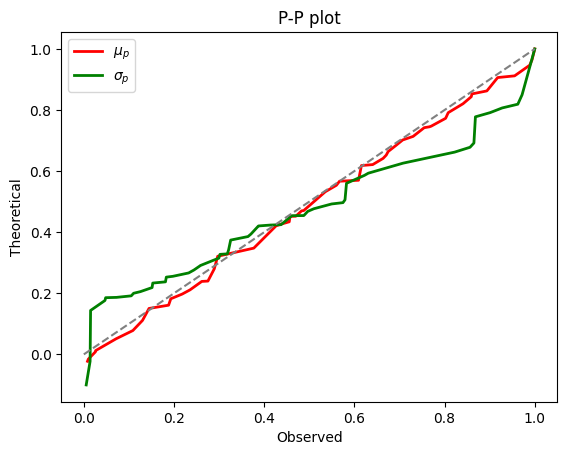

In [7]:
x = np.linspace(0,1,len(MU_P))
plt.plot(np.sort(MU_P/np.amax(MU_P)), np.sort(MU_P_RECORDED/np.amax(MU_P_RECORDED)), label='$\mu_p$', color='red', linewidth=2)
plt.plot(np.sort(SIGMA_P/np.amax(SIGMA_P)), np.sort(SIGMA_P_RECORDED/np.amax(SIGMA_P_RECORDED)), label='$\sigma_p$', color='green', linewidth=2)
plt.plot(x,x, linestyle='--', color='grey')
plt.ylabel('Theoretical')
plt.xlabel('Observed')
plt.legend()
plt.title("P-P plot")